In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import os
import time
import time
import json
import random
import numpy as np
from PIL import Image

In [2]:
devices = tf.config.experimental.list_physical_devices("GPU")
for device in devices:
    tf.config.experimental.set_memory_growth(device, enable=True)


In [3]:
annotation_folder = 'Flickr8k_text'
image_folder = 'Flickr8k_Dataset\Flicker8k_Dataset'

In [4]:
annotation_file = os.path.join(annotation_folder, "Flickr8k.token.txt")
with open(annotation_file, "r") as file:
    annotations = file.read()
    file.close()
annotations.split("\n")[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [5]:
image_path_to_caption = collections.defaultdict(list)
for line in annotations.split('\n'):
    image_name = line.split("#")[0]
    caption = line.split("\t")[-1]
    caption = f"<start>  {caption} <end>"
    image_path = os.path.join(image_folder, image_name)
    if image_path.endswith(".jpg"):
        image_path_to_caption[image_path].append(caption)

In [6]:
image_path_to_caption[os.path.join(image_folder, "1000268201_693b08cb0e.jpg")]

['<start>  A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start>  A girl going into a wooden building . <end>',
 '<start>  A little girl climbing into a wooden playhouse . <end>',
 '<start>  A little girl climbing the stairs to her playhouse . <end>',
 '<start>  A little girl in a pink dress going into a wooden cabin . <end>']

In [7]:
train_image_paths = list(image_path_to_caption.keys())
random.shuffle(train_image_paths)
print(len(train_image_paths))

8091


In [8]:
train_captions = []
image_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    image_name_vector.extend([image_path] * len(caption_list))

In [9]:
print(train_captions[0])

<start>  A child in formal clothing is walking along the edge of a stony area that is littered in places . <end>


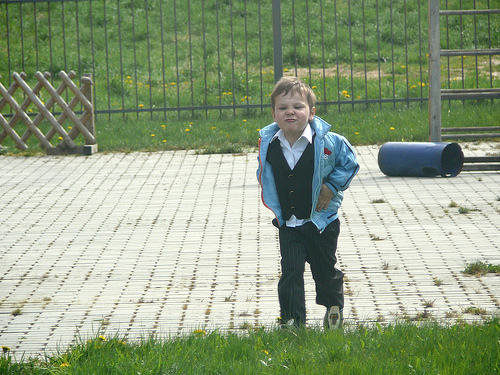

In [10]:
Image.open(image_name_vector[0])

In [11]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, image_path

In [12]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [13]:
encode_train = sorted(set(image_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image).batch(32)

In [14]:
from tqdm import tqdm
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_features = p.numpy().decode("utf-8")
        np.save(path_of_features, bf.numpy())

  0%|          | 0/253 [00:00<?, ?it/s]

100%|██████████| 253/253 [13:31<00:00,  3.21s/it]


In [15]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [16]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words= top_k, oov_token="<unk>", filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [17]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [18]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [19]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding="post")

In [20]:
max_length = calc_max_length(train_seqs)
max_length

39

In [21]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(image_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)
    

In [22]:
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

In [23]:
img_name_train_keys[1]

'Flickr8k_Dataset\\Flicker8k_Dataset\\3487378989_c051d2715b.jpg'

In [24]:
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

In [25]:
img_name_val, cap_val = [], []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [26]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32360, 32360, 8095, 8095)

In [27]:
batch_size = 16
buffer_size = 500
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train)
features_shape = 2048
attention_features_shape = 16

In [28]:
def map_func(image_name, cap):
    img_tensor = np.load(image_name.decode("utf-8") + ".npy")
    return img_tensor, cap

In [29]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

In [30]:
dataset = dataset.map(lambda item1, item2:tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]))

In [31]:
dataset = dataset.shuffle(buffer_size).batch(batch_size)

In [45]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w1 = tf.keras.layers.Dense(units)
        self.w2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = tf.nn.tanh(self.w1(features) + self.w2(hidden_with_time_axis))
        score = self.V(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [46]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
        
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [47]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)
        
    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [48]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [49]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype = loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [50]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder = encoder, decoder = decoder, optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [52]:
start_epoch = 1
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [53]:
loss_plot = []

In [54]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index["<start>"]] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            prediction, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:,i], prediction)
            dec_input = tf.expand_dims(target[:, i], 1)        
    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, total_loss


In [55]:
epochs = 20
for epoch in range (start_epoch, epochs):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        
        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy() / int(target.shape[1])
            print(f"Epoch {epoch + 1} Batch {batch} Loss {average_batch_loss:.4f}")
        loss_plot.append(total_loss / num_steps)
            
    if epoch % 5 == 0:
        ckpt_manager.save()
    print(f"Epoch {epoch + 1 } Loss {total_loss / num_steps:.6f}")
    print(f"Time taken for 1 epoch {time.time() - start:.2f} sec\n")

Epoch 2 Batch 0 Loss 2.1838
Epoch 2 Batch 100 Loss 1.4192
Epoch 2 Batch 200 Loss 1.4652
Epoch 2 Batch 300 Loss 1.2476
Epoch 2 Batch 400 Loss 1.1147
Epoch 2 Batch 500 Loss 1.0149
Epoch 2 Batch 600 Loss 1.0651
Epoch 2 Batch 700 Loss 1.2079
Epoch 2 Batch 800 Loss 0.9563
Epoch 2 Batch 900 Loss 1.3147
Epoch 2 Batch 1000 Loss 1.1982
Epoch 2 Batch 1100 Loss 0.9133
Epoch 2 Batch 1200 Loss 1.0253
Epoch 2 Batch 1300 Loss 1.2190
Epoch 2 Batch 1400 Loss 1.0946
Epoch 2 Batch 1500 Loss 1.1137
Epoch 2 Batch 1600 Loss 0.9721
Epoch 2 Batch 1700 Loss 0.9594
Epoch 2 Batch 1800 Loss 1.0143
Epoch 2 Batch 1900 Loss 1.0966
Epoch 2 Batch 2000 Loss 0.8877
Epoch 2 Loss 0.070070
Time taken for 1 epoch 2557.81 sec

Epoch 3 Batch 0 Loss 1.0681
Epoch 3 Batch 100 Loss 1.0693
Epoch 3 Batch 200 Loss 1.1713
Epoch 3 Batch 300 Loss 0.9353
Epoch 3 Batch 400 Loss 0.8073
Epoch 3 Batch 500 Loss 1.0220
Epoch 3 Batch 600 Loss 0.8703
Epoch 3 Batch 700 Loss 1.0130
Epoch 3 Batch 800 Loss 0.8684
Epoch 3 Batch 900 Loss 1.0052
Epoch

In [98]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    
    hidden = decoder.reset_state(batch_size=1)
    
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    
    features = encoder(img_tensor_val)
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        
        attention_weights_selected = attention_weights[0, :16, 0]
        attention_plot[i] = attention_weights_selected.numpy()

        #attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])
        
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [102]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))
    
    fig = plt.figure(figsize=(10, 10))
    
    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)'
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
    plt.tight_layout()
    plt.show()

Real Caption: <start> bike rider riding downhill in forest <end>
Prediction Caption: a man in a dirt bike is riding a dirt bike <end>


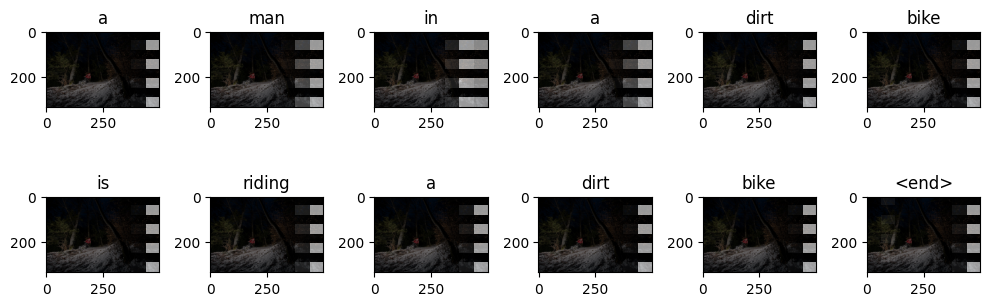

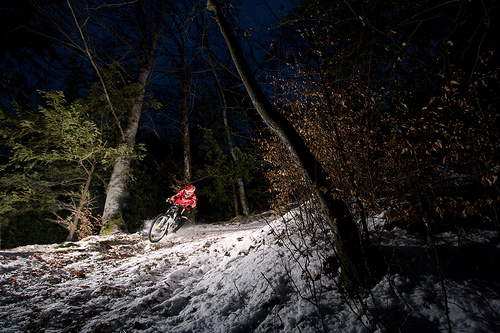

In [150]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

In [ ]:

image_path = ''
result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
Image.open(image_path)
